In [48]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [49]:
AlexNet = Sequential()

AlexNet.add(Conv2D(filters=96, input_shape=image_shape, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu'))
AlexNet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu'))
AlexNet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

AlexNet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
AlexNet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
AlexNet.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
AlexNet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

AlexNet.add(Flatten())

AlexNet.add(Dense(4096, activation='relu'))

AlexNet.add(Dense(4096, activation='relu'))

AlexNet.add(Dense(4096, activation='relu'))

AlexNet.add(Dense(2, activation='softmax'))

AlexNet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 11, 11, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 9, 9, 384)         885120    
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 384)        

In [38]:
os.chdir('C:\\Users\\sagni\\OneDrive\\Desktop\\Project Practice Data\\BrainTumorDataset\\Train')
if os.path.isdir('train/Tumor_Positive') is False:
    os.makedirs('train/Tumor_Positive')
    os.makedirs('train/Tumor_Negative')
    os.makedirs('valid/Tumor_Positive')
    os.makedirs('valid/Tumor_Negative')
    os.makedirs('test/Tumor_Positive')
    os.makedirs('test/Tumor_Negative')

    for c in random.sample(glob.glob('Tumor_Negative*'), 350):
        shutil.move(c, 'train/Tumor_Negative')
    for c in random.sample(glob.glob('Tumor_Positive*'), 350):
        shutil.move(c, 'train/Tumor_Positive')
    for c in random.sample(glob.glob('Tumor_Negative*'), 150):
        shutil.move(c, 'valid/Tumor_Negative')
    for c in random.sample(glob.glob('Tumor_Positive*'), 150):
        shutil.move(c, 'valid/Tumor_Positive')
    for c in random.sample(glob.glob('Tumor_Negative*'), 50):
        shutil.move(c, 'test/Tumor_Negative')
    for c in random.sample(glob.glob('Tumor_Positive*'), 50):
        shutil.move(c, 'test/Tumor_Positive')

os.chdir('../../')

In [50]:
train_path = 'C:\\Users\\sagni\\OneDrive\\Desktop\\Project Practice Data\\BrainTumorDataset\\Train\\train'
valid_path = 'C:\\Users\\sagni\\OneDrive\\Desktop\\Project Practice Data\\BrainTumorDataset\\Train\\valid'
test_path = 'C:\\Users\\sagni\\OneDrive\\Desktop\\Project Practice Data\\BrainTumorDataset\\Train\\test'

In [51]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

image_shape = (227, 227, 3)

train_batches = ImageDataGenerator(preprocessing_function=preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=image_shape[:2], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=image_shape[:2], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=image_shape[:2], batch_size=10, shuffle=False)

Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [41]:
#train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.alexnet.preprocess_input) \
    #.flow_from_directory(directory=train_path, target_size=(224,224), classes=['Tumor_Negative', 'Tumor_Positive'], batch_size=10)
#valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.alexnet.preprocess_input) \
    #.flow_from_directory(directory=valid_path, target_size=(224,224), classes=['Tumor_Negative', 'Tumor_Positive'], batch_size=10)
#test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.alexnet.preprocess_input) \
    #.flow_from_directory(directory=test_path, target_size=(224,224), classes=['Tumor_Negative', 'Tumor_Positive'], batch_size=10, shuffle=False)

In [52]:
assert train_batches.n == 700
assert valid_batches.n == 300
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [53]:
imgs, labels = next(train_batches)

In [54]:
import matplotlib.pyplot as plt

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

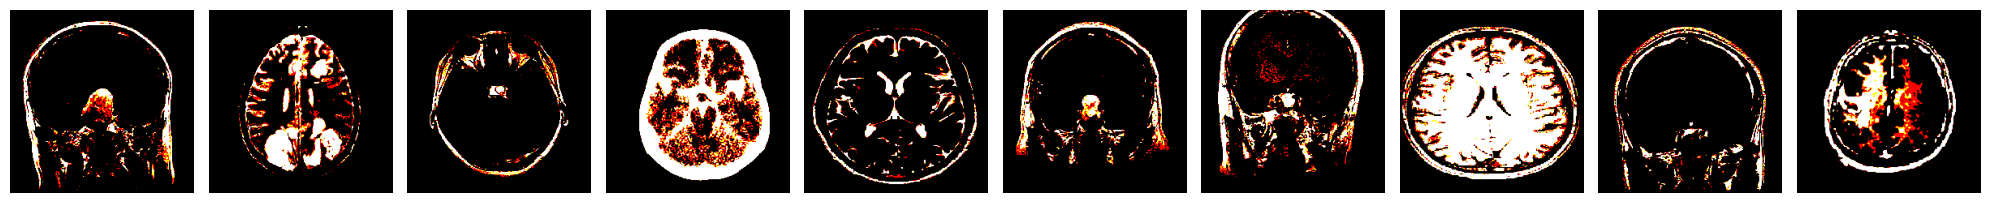

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [55]:
plotImages(imgs)
print(labels)

In [56]:
AlexNet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
history = AlexNet.fit(x=train_batches, validation_data=valid_batches, epochs=20, verbose=2)

Epoch 1/20
70/70 - 85s - loss: 0.9826 - accuracy: 0.6300 - val_loss: 0.5929 - val_accuracy: 0.7567 - 85s/epoch - 1s/step
Epoch 2/20
70/70 - 78s - loss: 0.4423 - accuracy: 0.8029 - val_loss: 0.2992 - val_accuracy: 0.8533 - 78s/epoch - 1s/step
Epoch 3/20
70/70 - 78s - loss: 0.3114 - accuracy: 0.8686 - val_loss: 0.2272 - val_accuracy: 0.9167 - 78s/epoch - 1s/step
Epoch 4/20
70/70 - 79s - loss: 0.2743 - accuracy: 0.8857 - val_loss: 0.3861 - val_accuracy: 0.8433 - 79s/epoch - 1s/step
Epoch 5/20
70/70 - 72s - loss: 0.3209 - accuracy: 0.8500 - val_loss: 0.2770 - val_accuracy: 0.8800 - 72s/epoch - 1s/step
Epoch 6/20
70/70 - 69s - loss: 0.1996 - accuracy: 0.9186 - val_loss: 0.3641 - val_accuracy: 0.8433 - 69s/epoch - 991ms/step
Epoch 7/20
70/70 - 68s - loss: 0.1505 - accuracy: 0.9414 - val_loss: 0.2815 - val_accuracy: 0.8933 - 68s/epoch - 978ms/step
Epoch 8/20
70/70 - 77s - loss: 0.1194 - accuracy: 0.9529 - val_loss: 0.1659 - val_accuracy: 0.9333 - 77s/epoch - 1s/step
Epoch 9/20
70/70 - 74s - l

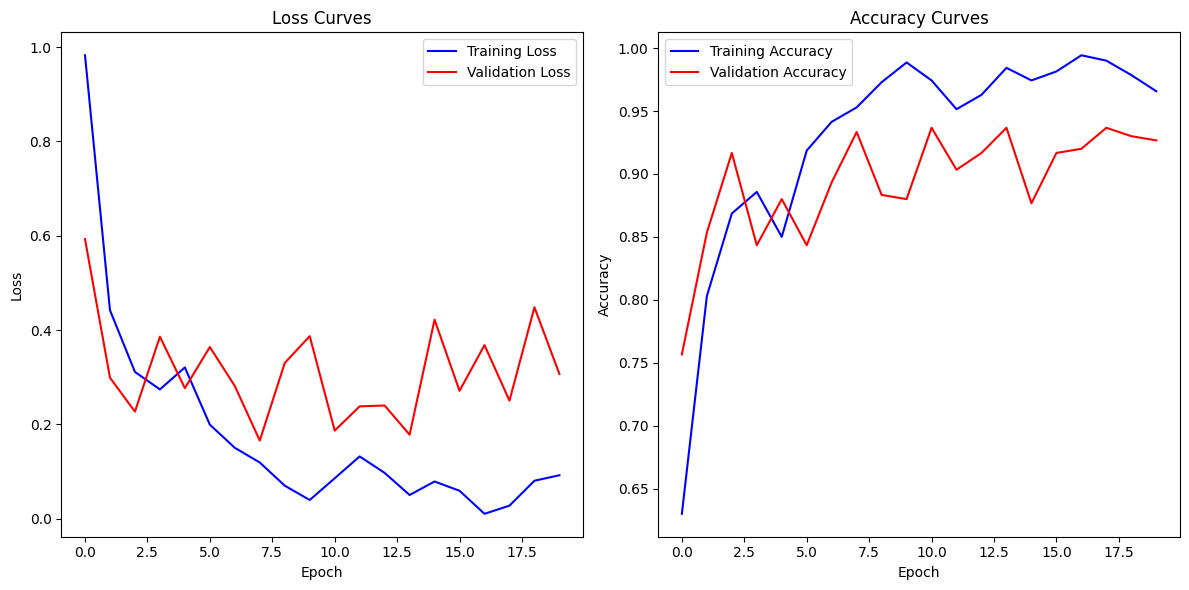

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
AlexNet.save('MyAlexNet4.h5')

In [57]:
MyModel=load_model('MyAlexNet4.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

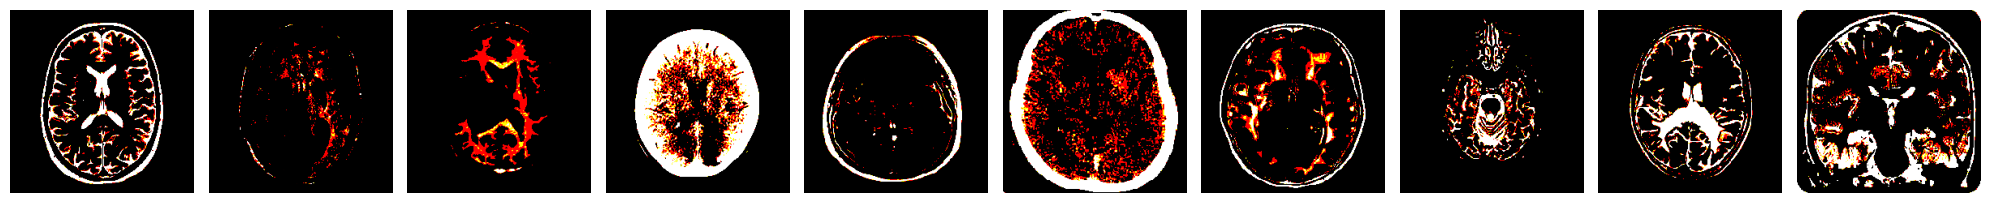

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
predictions = MyModel.predict(x=test_batches, verbose=0)

In [ ]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
test_batches.class_indices

{'Tumor_Negative': 0, 'Tumor_Positive': 1}

Confusion matrix, without normalization
[[50  0]
 [ 3 47]]


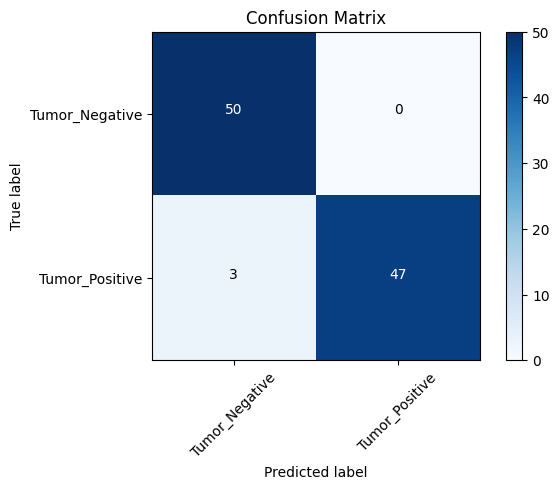

In [ ]:
cm_plot_labels = ['Tumor_Negative','Tumor_Positive']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')